In [5]:
import pickle

# Import raw data. Format is list of dicts, each with
# 'label' and 'data' keys.

# sit_walk data
with open("sit_walk.pkl",'rb') as f:
    sit_walk_data = pickle.load(f)
    
# run data
with open("run.pkl",'rb') as f:
    run_data = pickle.load(f)

# sit data
with open("sit1.pkl",'rb') as f:
    sit_data = pickle.load(f)

# slip data
with open("slip.pkl",'rb') as f:
    slip_data = pickle.load(f)
    
#for sample in sit_data:
    #print(len(sample['data']))

In [6]:
from random import shuffle

# CLEAN UP DATA
# define sample length - that is, how many measurements the samples that
# are passed to the SVM will include. Based on smallest sample in slip_data.
sample_length = 1000; #aribtary high number for min comparison
for sample in slip_data:
    if len(sample['data']) < sample_length:
        sample_length = len(sample['data'])
print('sample length:', sample_length)

# new data containers
slip_data_fixed_length = []
sit_walk_data_fixed_length = []
run_data_fixed_length = []
sit_data_fixed_length = []

# Extract maximum number of data samples from raw data, and shuffle.
for experiment in slip_data:
    experiment['label'] = 'slip'
    for i in range(len(experiment['data']) - sample_length):
        temp = {}
        temp['label'] = 'slip'
        temp['data'] = experiment['data'][i:i+sample_length]
        slip_data_fixed_length.append(temp)
shuffle(slip_data_fixed_length)

for experiment in sit_data:
    experiment['label'] = 'sit'
    for i in range(len(experiment['data']) - sample_length):
        temp = {}
        temp['label'] = 'sit'
        temp['data'] = experiment['data'][i:i+sample_length]
        sit_data_fixed_length.append(temp)
shuffle(sit_data_fixed_length)
        
for experiment in run_data:
    experiment['label'] = 'run'
    for i in range(len(experiment['data']) - sample_length):
        temp = {}
        temp['label'] = 'run'
        temp['data'] = experiment['data'][i:i+sample_length]
        run_data_fixed_length.append(temp)
shuffle(run_data_fixed_length)

for experiment in sit_walk_data:
    experiment['label'] = 'sit_walk'
    for i in range(len(experiment['data']) - sample_length):
        temp = {}
        temp['label'] = 'sit_walk'
        temp['data'] = experiment['data'][i:i+sample_length]
        sit_walk_data_fixed_length.append(temp)
shuffle(sit_walk_data_fixed_length)

print(len(sit_data_fixed_length))

sample length: 9
0


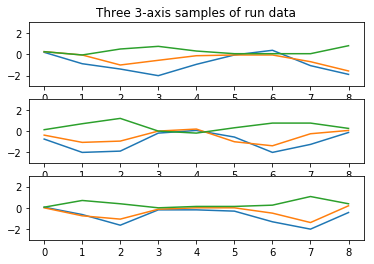

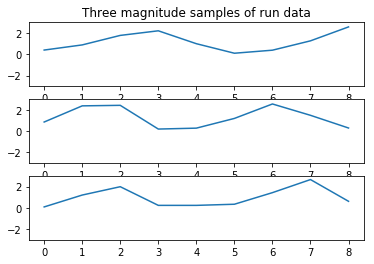

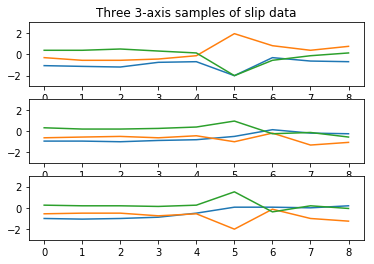

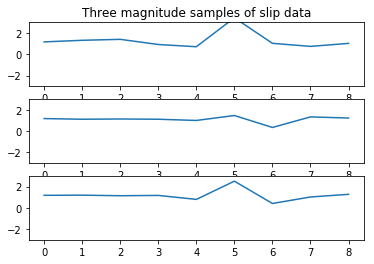

In [7]:
import matplotlib.pyplot as plt
import numpy as np


# PLOT SOME DATA

# FUNCTIONS

# plot 3 samples of 3-axis data
def plot_xyz(samples):
    for i in range(3):
        x_vals = []
        y_vals = []
        z_vals = []
        for x,y,z in samples[i]['data']:
            x_vals.append(x)
            y_vals.append(y)
            z_vals.append(z)
        plt.subplot(3,1,i+1)
        plt.plot(x_vals)
        plt.plot(y_vals)
        plt.plot(z_vals)
        plt.ylim(-3, 3)
    # return to top subplot to add title
    plt.subplot(3,1,1)
    plt.title('Three 3-axis samples of {} data'.format(samples[0]['label']))
    plt.show()
    
# PLOT SOME DATA
# plot 2 samples of magnitude data
def plot_magnitudes(samples):
    for i in range(3):
        mags = []
        for x,y,z in samples[i]['data']:
            mag = (x**2 + y**2 + z**2)**0.5
            mags.append(mag)
        plt.subplot(3,1,i+1)
        plt.plot(mags)
        plt.ylim(-3, 3)
    # return to top subplot to add title
    plt.subplot(3,1,1)
    plt.title('Three magnitude samples of {} data'.format(samples[0]['label']))
    plt.show()

############################################
# PLOT SAMPLES TO COMPARE XYZ FORMAT TO
# MAGNITUDE FORMAT

# Show run data
plot_xyz(run_data_fixed_length)
plot_magnitudes(run_data_fixed_length)

# Show slip data
plot_xyz(slip_data_fixed_length)
plot_magnitudes(slip_data_fixed_length)

In [8]:
# Create magnitude samples for each class

def xyz_to_mag(samples):
    for sample in samples:
        temp = []
        for x,y,z in sample['data']:
            val = (x**2 + y**2 + z**2)**0.05
            temp += [val]
        sample['data'] = temp

In [9]:
# create negative data container.        
negative_data = []
# combine samples from all negative classes
negative_data += sit_data_fixed_length
negative_data += sit_walk_data_fixed_length
negative_data += run_data_fixed_length
for sample in negative_data:
    sample['label'] = 'negative'
print('Total negative data samples:', len(negative_data))
# shuffle negative data to get mix of states
shuffle(negative_data)

# create positive data container
positive_data = []
positive_data += slip_data_fixed_length
for sample in positive_data:
    sample['label'] = 'positive'
print('Total positive data samples:', len(positive_data))

# Data to be used with SVM: includes all positive samples + twice as
# many negative samples to give a 1/3 ratio of pos to neg.
used_data = positive_data + negative_data[0:2*len(positive_data)]
shuffle(used_data)

# surplus negative samples - may be good for testing later.
unused_data = negative_data[2*len(positive_data):]

# convert samples in used_data into single lists of sample_length*3 measurements, 
# instead of being lists of sample_length, that contain lists of [x,y,z] values:
for sample in used_data:
    temp = []
    for reading in sample['data']:
        for num in reading:
            temp += [num]
    sample['data'] = temp
    
# create data and label lists for SVM
x_used = [sample['data'] for sample in used_data]
y_used = [sample['label'] for sample in used_data]
print('\nNumber of samples being used:', len(x_used))
print('(all positive samples + enough negative samples to give a 1:3 ratio.)')

# Parse into test and train set. Finally, these are what will be 
# passed to the SVM.
break_point = int(2*len(x_used)/3)
x_train = x_used[0:break_point]
y_train = y_used[0:break_point]
x_test = x_used[break_point:]
y_test = y_used[break_point:]
print('Training data size:', len(x_train))
print('Test data size:', len(x_test))

Total negative data samples: 516
Total positive data samples: 24

Number of samples being used: 72
(all positive samples + enough negative samples to give a 1:3 ratio.)
Training data size: 48
Test data size: 24


In [10]:
from sklearn import svm
from sklearn.metrics import classification_report

# create and fit SVM model
clf = svm.SVC()
clf.fit(x_train, y_train)  

print('\nSVM test result:\n', classification_report(y_test, clf.predict(x_test)))


SVM test result:
               precision    recall  f1-score   support

    negative       0.88      0.93      0.90        15
    positive       0.88      0.78      0.82         9

   micro avg       0.88      0.88      0.88        24
   macro avg       0.88      0.86      0.86        24
weighted avg       0.88      0.88      0.87        24



/Users/user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
